In [1]:
# %pylab inline --no-import-all
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from numpy import sqrt, exp, sinh

plt.rcParams['figure.figsize'] = 16, 9

# Numerov's Method

In [2]:
def numerov_step(k0, k1, k2, psi0, psi1, dx):
    """compute psi2 via a single numerov step"""
    dd = dx**2/12.
    c0 = (1 + dd * k0)
    c1 = 2 * (1 - 5 * dd * k1)
    c2 = (1 + dd * k2)
    return (c1 * psi1 - c0 * psi0) / c2

As a basic test, let's check the "symmetry property" of a single Numerov step:

In [3]:
assert np.isclose(numerov_step(2, 4, 7, numerov_step(7, 4, 2, 2, 4, .25), 4, .25), 2)

#### Low-Level Numerov

In [4]:
def numerov_iter(ks, psi0, psi1, dx):
    """compute psis = [psi0, psi1, psi2, ...] for ks = [k0, k1, ...] via iterated numerov steps"""
    n = len(ks)
    psis = np.zeros(n, dtype=np.complex128)
    psis[0] = psi0
    psis[1] = psi1
    for i in range(2, n):
        psis[i] = numerov_step(ks[i-2], ks[i-1], ks[i], psis[i-2], psis[i-1], dx)
    return psis

#### High-Level Numerov

#### Single Step

In [5]:
def numerov(k, psi0, psi1, x_min, x_max, n):
    """compute psis = [psi0, psi1, ...] for k = k(x) according to given discretization"""
    xs, dx = np.linspace(x_min, x_max, num=n, retstep=True)
    ks = np.vectorize(k)(xs)
    return xs, numerov_iter(ks, psi0, psi1, dx)

def numerov_right_to_left(k, psi_2ndlast, psi_last, x_min, x_max, n):
    """compute psis = [..., psi_2ndlast, psi_last] for k = k(x) according to given discretization"""
    xs, dx = np.linspace(x_min, x_max, num=n, retstep=True)
    ks = np.vectorize(k)(xs)
    return xs, numerov_iter(ks[::-1], psi_last, psi_2ndlast, dx)[::-1]

#### Scattering Coefficients

In [6]:
def scatter(V, E, x_min, x_max, n, return_xs_psis=False):
    """compute transmission & reflection coefficient for given potential and energy (and m = hbar = 1)"""
    # compute step size
    dx = (x_max - x_min) / float(n)

    # start with right-travling wave at energy E (w/ phase fixed to 1 at x_max)
    q_free = sqrt(2. * E)
    psi_2nd_last = 1
    psi_last = exp(1j * q_free * dx)

    # compute resulting solution using Numerov
    def k(x):
        return 2. * (E - V(x))
    xs, psis = numerov_right_to_left(k, psi_2nd_last, psi_last, x_min - dx, x_max + dx, n + 2)
    
    # fit psis[] to A * exp(iqx) + B * exp(-iqx)
    A, B = np.linalg.solve(
        [[exp(1j*q_free*(-dx)), exp(-1j*q_free*(-dx))],
         [1, 1]],
        [psis[0], psis[1]])
    
    # extract transmission and reflection coefficients
    T = 1 / abs(A)**2
    R = abs(B)**2 / abs(A)**2
    return (T, R, xs, psis) if return_xs_psis else (T, R)

"Test" with a free particle:

In [7]:
assert np.allclose(scatter(V=lambda _: 0, E=1, x_min=0, x_max=1, n=1e5), [1, 0])

# Rectangular Potential

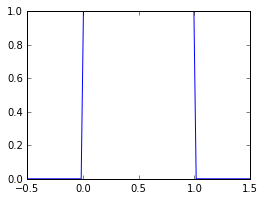

In [8]:
def rect_potential(a):
    def V(x):
        return float(0 < x <= a)
    return V

xs = np.linspace(-0.5, 1.5, num=100)
plt.figure(figsize=(4, 3))
plt.plot(xs, [rect_potential(a=1)(x) for x in xs])
plt.show()

#### Wave Function

This is a bit of a hack...

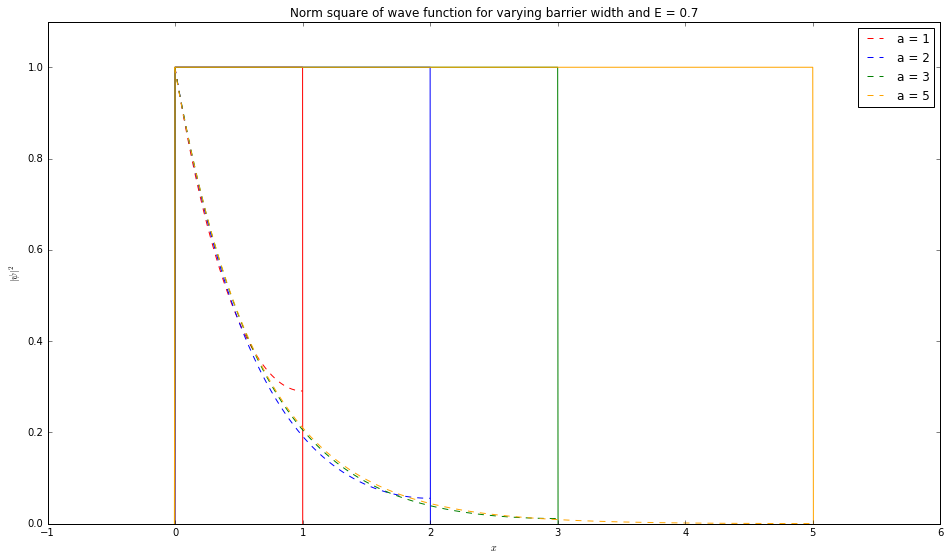

In [9]:
plt.title('Norm square of wave function for varying barrier width and E = 0.7')
plt.xlabel('$x$')
plt.ylabel('$|\psi|^2$')
plt.ylim(0, 1.1)
for a, color in zip([1, 2, 3, 5], ['red', 'blue', 'green', 'orange']):
    V = rect_potential(a=a)
    T, _, xs, psis = scatter(V=V, E=0.7, x_min=0, x_max=a, n=1000, return_xs_psis=True)
    plt.plot(xs, [V(x) for x in xs], color=color)
    plt.plot(xs, np.abs(psis)**2/np.abs(psis[0])**2, '--', color=color, label='a = %s' % a)
plt.legend()
plt.show()
V = rect_potential(a=1)
T, _, xs, psis = scatter(V=V, E=0.5, x_min=0, x_max=1, n=1000, return_xs_psis=True)

#### Analytical expression for the transmission probability:

In [10]:
def transmission_exact(a, E):
    assert not np.isclose(E,1.)
    kappa = sqrt(2 * (1-E)+0j)
    return 1. / (1 + sinh(kappa*a)**2 / (4. * E * (1-E))).real

#### Convergence to the Analytical Value

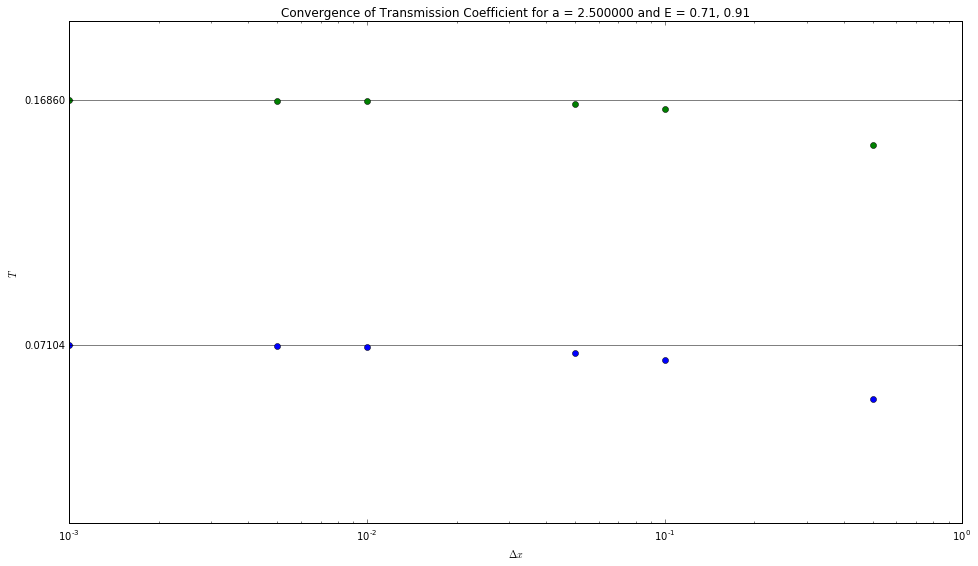

In [11]:
a = 2.5
V = rect_potential(a=a)
Es = [0.71, 0.91]
Ts_exact = [transmission_exact(a=a, E=E) for E in Es]
step_sizes = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

plt.title('Convergence of Transmission Coefficient for a = %f and E = %s' % (a, ', '.join(map(str, Es))))
plt.xlabel('$\Delta x$')
plt.ylabel('$T$')
plt.ylim((0, 0.2))
plt.yticks(Ts_exact)
for E, T_exact in zip(Es, Ts_exact):
    # show theoretical value as horizontal line
    plt.axhline(T_exact, color='gray')
    
    # plot numerical data points
    Ts_approx = [scatter(V=V, E=E, x_min=0, x_max=a, n=int(np.ceil(a / dx)))[0] for dx in step_sizes]
    plt.semilogx(step_sizes, Ts_approx, 'o')
plt.show()

#### Dependence on Energy

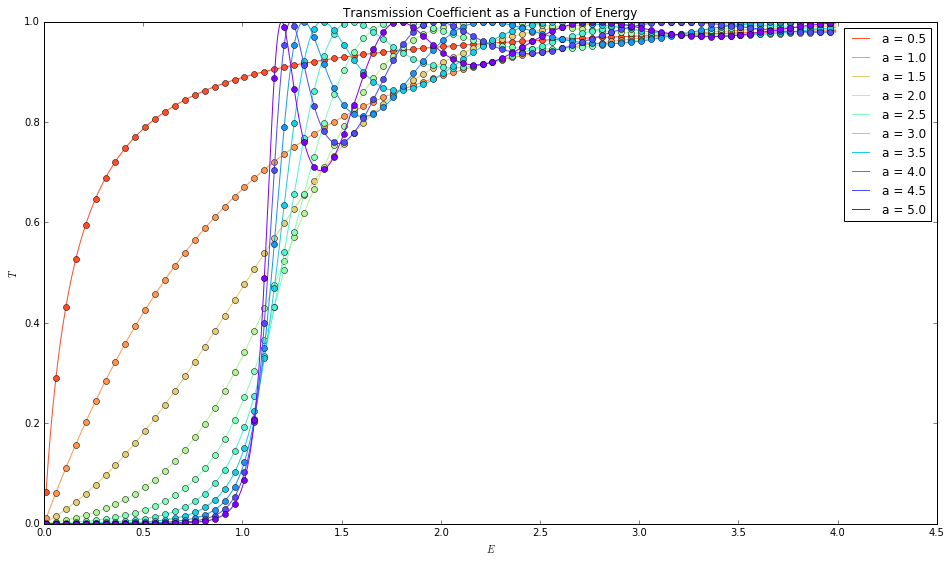

In [12]:
as_ = np.linspace(0.5, 5, 10)
colors = cm.rainbow(1 - as_ / 5)
Es = np.linspace(.01, 3.99,1000)
Es_coarse = np.arange(.01, 4., .05)
n = 1e3

plt.title('Transmission Coefficient as a Function of Energy')
plt.xlabel('$E$')
plt.ylabel('$T$')
plt.xlim(0, 4.5)
for a, color in zip(as_, colors):
    # plot theoretical value
    plt.plot(Es, [transmission_exact(a=a, E=E) for E in Es], color=color, label='a = %.1f' % a)
    
    # plot numerical data points
    Ts_approx = [scatter(V=rect_potential(a), E=E, x_min=0, x_max=a, n=n)[0] for E in Es_coarse]
    l = plt.plot(Es_coarse, Ts_approx, 'o', color=color)
plt.legend(loc='upper right')
plt.show()

#### Dependence on Barrier Width

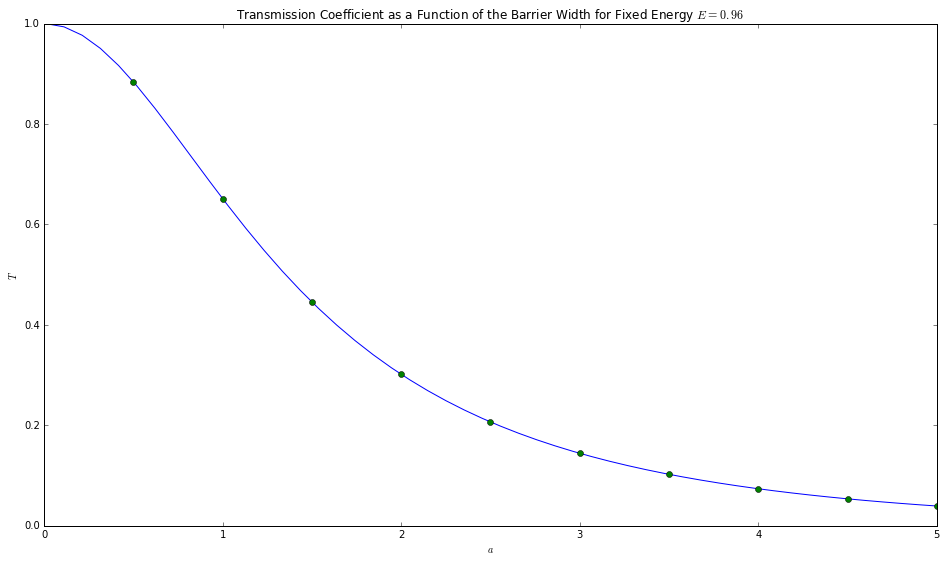

In [13]:
E = .96
as_ = np.linspace(.01, 5)
as_coarse = np.linspace(0.5, 5, 10)
n = 1e3

plt.title('Transmission Coefficient as a Function of the Barrier Width for Fixed Energy $E = %s$' % E)
plt.xlabel('$a$')
plt.ylabel('$T$')
plt.ylim(0, 1)
plt.plot(as_, [transmission_exact(a=a, E=E) for a in as_])
plt.plot(as_coarse, [scatter(V=rect_potential(a=a), E=E, x_min=0, x_max=a, n=n)[0] for a in as_coarse], 'o')
plt.show()

## Parabolic Potential

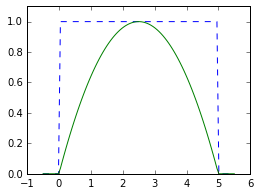

In [14]:
def parabolic_potential(a):
    a = float(a)
    def V(x):
        if 0 < x <= a:
            return 4. * (x / a  - x**2 / a**2)
        return 0.
    return V

xs = np.linspace(-0.5, 5.5, num=100)
plt.figure(figsize=(4, 3))
plt.ylim(0, 1.1)
plt.plot(xs, [rect_potential(a=5)(x) for x in xs], '--')
plt.plot(xs, [parabolic_potential(a=5)(x) for x in xs])
plt.show()

#### Compare Dependence on Energy

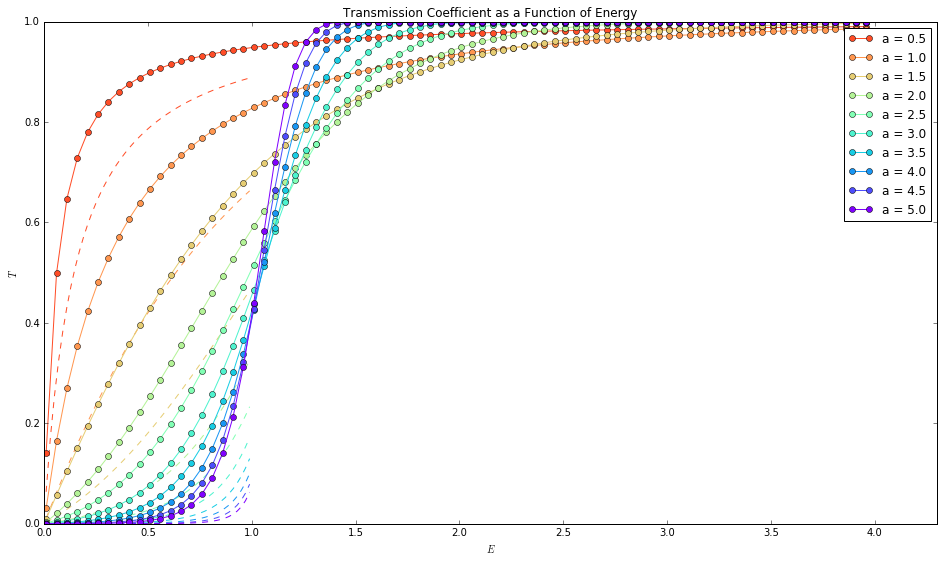

In [15]:
as_ = np.linspace(0.5, 5, 10)
colors = cm.rainbow(1 - as_ / 5)
Es = np.linspace(.01, .99)
Es_coarse = np.arange(.01, 4, .05)
n = 1e3

plt.title('Transmission Coefficient as a Function of Energy')
plt.xlabel('$E$')
plt.ylabel('$T$')
plt.xlim(0, 4.3)
for a, color in zip(as_, colors):
    # plot theoretical value
    plt.plot(Es, [transmission_exact(a=a, E=E) for E in Es], '--', color=color)
    
    # plot numerical data points
    Ts_parabolic = [scatter(V=parabolic_potential(a), E=E, x_min=0, x_max=a, n=n)[0] for E in Es_coarse]
    l = plt.plot(Es_coarse, Ts_parabolic, 'o-', color=color, label='a = %.1f' % a)
plt.legend()
plt.show()

#### Compare Dependence on Barrier Width

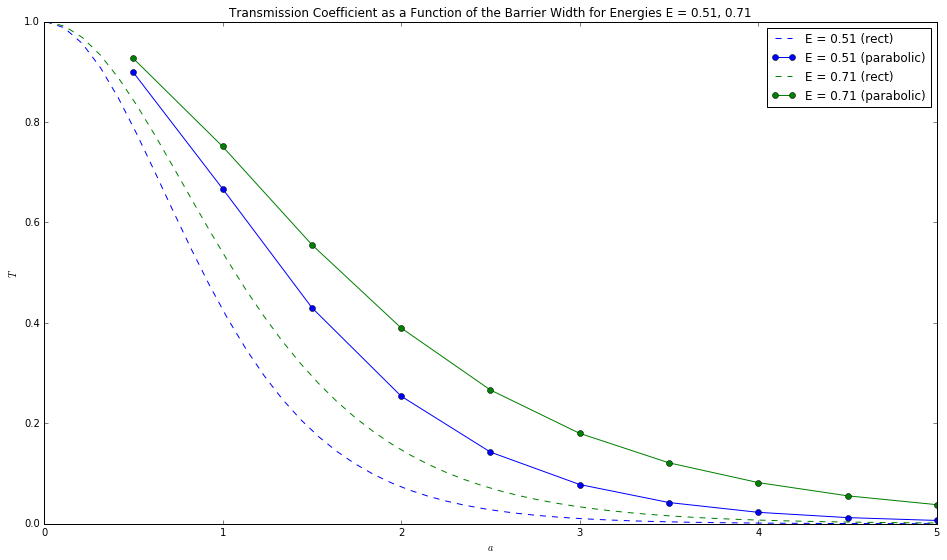

In [16]:
Es = [.51, .71]
colors = ['blue', 'green']
as_ = np.linspace(.01, 5)
as_coarse = np.linspace(0.5, 5, 10)
n = 1e3

plt.title('Transmission Coefficient as a Function of the Barrier Width for Energies E = %s' % ', '.join(map(str, Es)))
plt.xlabel('$a$')
plt.ylabel('$T$')
plt.ylim(0, 1)
for E, color in zip(Es, colors):
    plt.plot(as_, [transmission_exact(a=a, E=E) for a in as_], '--', color=color, label='E = %s (rect)' % E)
    plt.plot(as_coarse, [scatter(V=parabolic_potential(a=a), E=E, x_min=0, x_max=a, n=n)[0] for a in as_coarse], 'o-', label='E = %s (parabolic)' % E)
plt.legend()
plt.show()

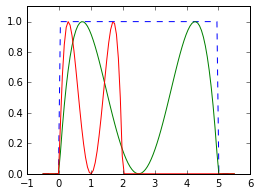

In [17]:
def bound_potential(a):
    a = float(a)
    def V(x):
        if 0 < x <= a:
            #return 0.4*(((x-a/2)/(a/2))**2 - ((x-a/2)/(a/2))**4) + 0.9
            return 4*(((x-a/2)/(a/2))**2 - ((x-a/2)/(a/2))**4)
        return 0.
    return V

xs = np.linspace(-0.5, 5.5, num=100)
plt.figure(figsize=(4, 3))
plt.ylim(0, 1.1)
plt.plot(xs, [rect_potential(a=5)(x) for x in xs], '--')
plt.plot(xs, [bound_potential(a=5)(x) for x in xs])
plt.plot(xs, [bound_potential(a=2)(x) for x in xs])
plt.show()

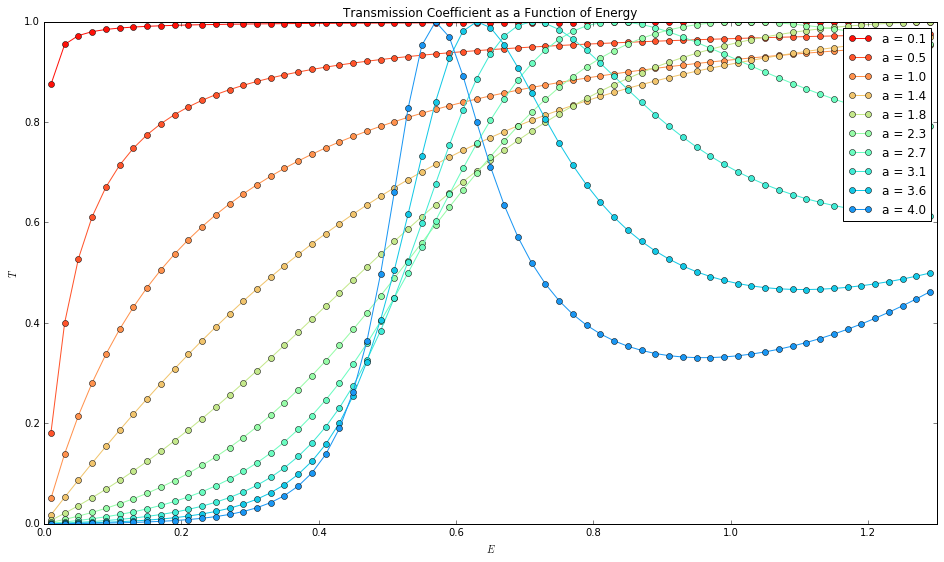

In [23]:
as_ = np.linspace(0.1, 4, 10)
colors = cm.rainbow(1 - as_ / 5)
Es_coarse = np.arange(.01, 1.3, .02)
n = 1e3

plt.title('Transmission Coefficient as a Function of Energy')
plt.xlabel('$E$')
plt.ylabel('$T$')
plt.xlim(0, 1.3)
for a, color in zip(as_, colors):
    # plot numerical data points
    Ts_parabolic = [scatter(V=bound_potential(a), E=E, x_min=0, x_max=a, n=n)[0] for E in Es_coarse]
    l = plt.plot(Es_coarse, Ts_parabolic, 'o-', color=color, label='a = %.1f' % a)
plt.legend()
plt.show()

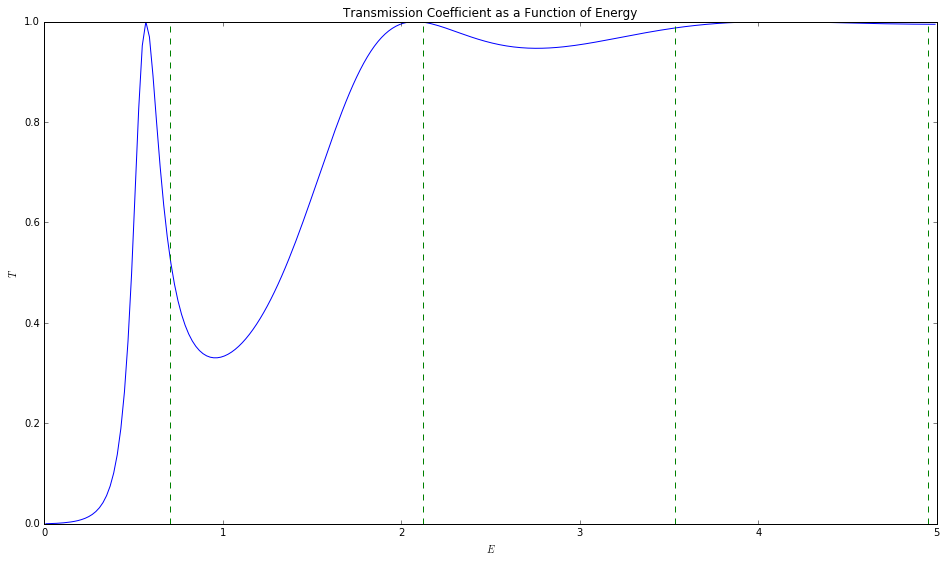

In [19]:
Es_coarse = np.arange(.01, 5.0, .02)
n = 5e3
a = 4.0

plt.title('Transmission Coefficient as a Function of Energy')
plt.xlabel('$E$')
plt.ylabel('$T$')
plt.xlim(0, 5.0)

# plot numerical data points
Ts_parabolic = [scatter(V=bound_potential(a), E=E, x_min=0, x_max=a, n=n)[0] for E in Es_coarse]
plt.plot(Es_coarse, Ts_parabolic, '-', label='a = %.1f' % a)
E_harm = lambda n: sqrt(2)*4/a*(n+0.5)
for n in range(5):
    plt.axvline(E_harm(n),color='g',linestyle='--')
plt.show()

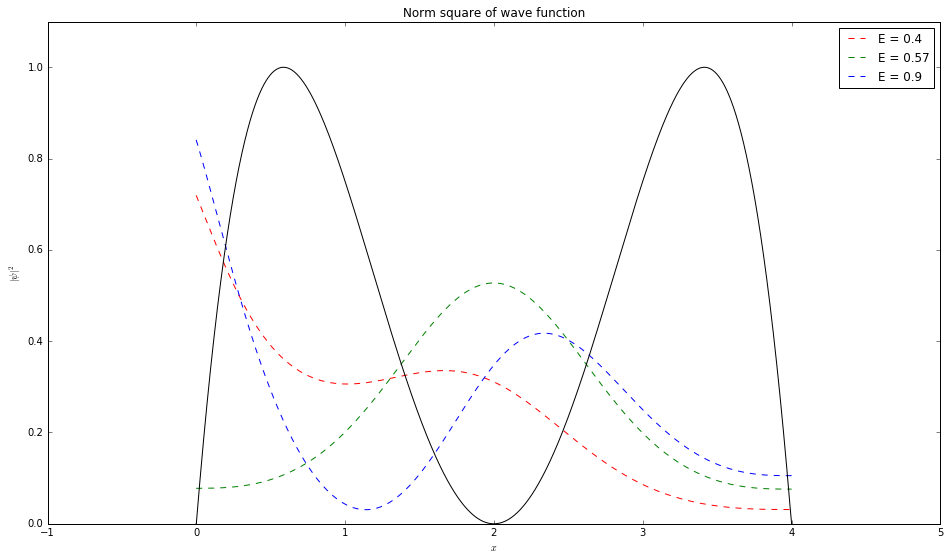

In [22]:
n = 5e3
a = 4.0

plt.title('Norm square of wave function')
plt.xlabel('$x$')
plt.ylabel('$|\psi|^2$')
plt.ylim(0, 1.1)
V = bound_potential(a)
for E,color in zip([0.4,0.57,0.9],['r','g','b']):
    T, _, xs, psis = scatter(V=V, E=E, x_min=0, x_max=a, n=n, return_xs_psis=True)
    norm = np.sum(np.abs(psis)**2)*a/n
    plt.plot(xs, np.abs(psis)**2/norm, '--', color=color, label='E = %s' % E)
plt.plot(xs, [V(x) for x in xs], color='k')
plt.legend()
plt.show()

# Playground

In [21]:
scatter(rect_potential(a=1), E=0.71, x_min=0, x_max=1, n=100000)

(0.54014292192623703, 0.45985707640796758)